In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,log_loss
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [2]:
df1 = pd.read_csv('/content/221.csv')
df2 = pd.read_csv('/content/230.csv')
print(df1.head())
print(df2.head())

   RESP  BP-S  BP-D  SpO2  HR  PULSE  Anomaly
0    28    81   120    98  74     73        0
1    29    81   120    98  74     73        0
2    30    81   120    98  74     73        0
3    30    81   120    99  74     73        0
4    29    81   120    99  73     73        0
   RESP  BP-S  BP-D  SpO2  HR  PULSE  Anomaly
0    15    54    73    97  72     71        0
1    15    54    73    97  72     71        0
2    15    54    73    97  72     71        0
3    15    54    73    97  72     71        0
4    15    55    74    97  72     71        0


In [3]:
no_of_missing1 = df1.isnull().sum() #missing values in patient 1
print("Patient 1\n",no_of_missing1,"\n")

no_of_missing2 = df2.isnull().sum() #missing values in patient 2
print("Patient 2\n",no_of_missing2)

Patient 1
 RESP       0
BP-S       0
BP-D       0
SpO2       0
HR         0
PULSE      0
Anomaly    0
dtype: int64 

Patient 2
 RESP       0
BP-S       0
BP-D       0
SpO2       0
HR         0
PULSE      0
Anomaly    0
dtype: int64


In [4]:
#finding the shape(no of rows and columns) of the datasets
print("Shape of Dataset of patient 1:", df1.shape)
print(f"Shape of Dataset of patient 2: {df2.shape}")

Shape of Dataset of patient 1: (24999, 7)
Shape of Dataset of patient 2: (25000, 7)


In [5]:
#finding the duplicated data in the dataset
print(f"Amount of duplicated data in patient 1 dataset: {df1.duplicated().sum()}")
print(f"Amount of duplicated data in patient 2 dataset: {df2.duplicated().sum()}")

Amount of duplicated data in patient 1 dataset: 9445
Amount of duplicated data in patient 2 dataset: 16551


In [6]:
features = ['RESP', 'BP-S', 'BP-D', 'SpO2', 'HR', 'PULSE']
target = 'Anomaly'

X_p1 = df1[features]
y_p1 = df1[target]

X_p2 = df2[features]
y_p2 = df2[target]

# Splitting both datasets into train and test sets (We are using 80% of the dataset for training and 20% for testing the model)
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = train_test_split(X_p1, y_p1, test_size=0.2, random_state=42)
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = train_test_split(X_p2, y_p2, test_size=0.2, random_state=42)

# ID3 using Scikit-Learn (Patient 1)

ID3 (Scikit-Learn) Accuracy on Patient 1: 0.9956


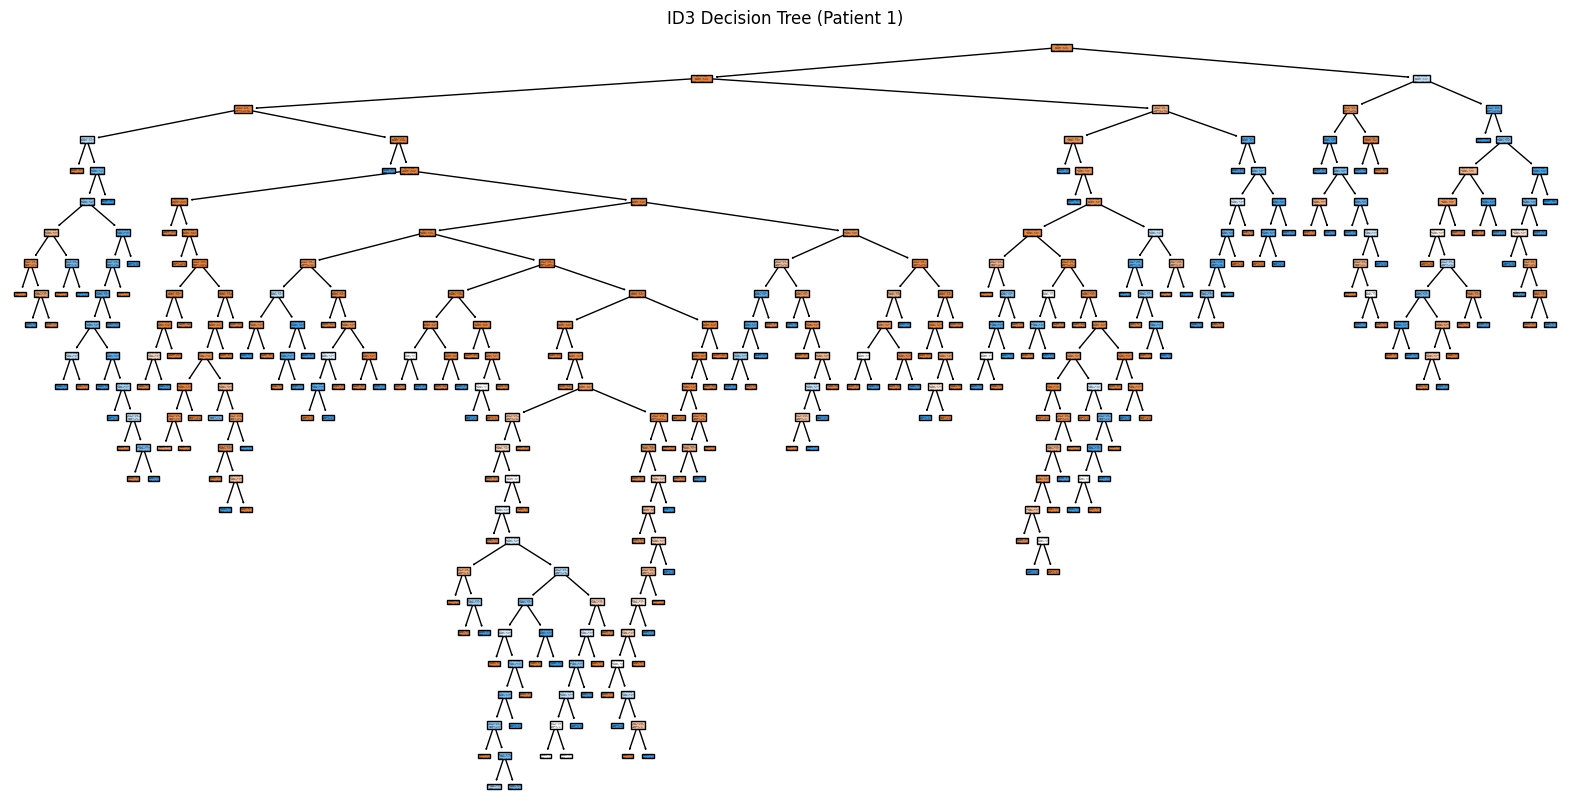

In [7]:
id3_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
id3_model.fit(X_train_p1, y_train_p1)

# Predicting and evaluating the model
y_pred_p1 = id3_model.predict(X_test_p1)
accuracy = accuracy_score(y_test_p1, y_pred_p1)
print("ID3 (Scikit-Learn) Accuracy on Patient 1:", accuracy)

# Plotting the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(id3_model, filled=True)
plt.title("ID3 Decision Tree (Patient 1)")
plt.show()

# ID3 Custom (Patient 1)

In [8]:
from collections import Counter
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTreeID3:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y):
        best_gain = -1
        split_idx, split_threshold = None, None

        n_samples, n_features = X.shape
        for feat_idx in range(n_features):
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):

        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Information gain
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, threshold):
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

xc = ['RESP', 'BP-S', 'BP-D', 'SpO2', 'HR', 'PULSE']
X = df1[xc].values
y = df1['Anomaly'].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state= 42)

id3_model = DecisionTreeID3(max_depth=10)
id3_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = id3_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("ID3  scratch Accuracy on Patient 1:", accuracy)

ID3  scratch Accuracy on Patient 1: 0.9934


# Performance Metrics

In [9]:
# Accuracy
accuracy = accuracy_score(y_test_p1, y_pred_p1)
print("ID3 (Scikit learn) Accuracy on Patient 1:", accuracy)

accuracy = accuracy_score(y_test, y_pred)
print("ID3 (Custom) Accuracy on Patient 1:", accuracy)

# Precision
precision = precision_score(y_test_p1, y_pred_p1, average='weighted')
print("\nPrecision(Scikit learn):", precision)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision(Custom):", precision)

# Recall
recall = recall_score(y_test_p1, y_pred_p1, average='weighted')
print("\nRecall(Scikit learn):", recall)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall(Custom):", recall)

# F1 Score
f1 = f1_score(y_test_p1, y_pred_p1, average='weighted')
print("\nF1 Score(Scikit learn):", f1)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score(Custom):", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_p1, y_pred_p1)
print("\nConfusion Matrix (Scikit learn):\n", conf_matrix)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Custom):\n", conf_matrix)

# Classification Report (includes precision, recall, and F1 score for each class)
print("\nClassification Report (Scikit learn):\n", classification_report(y_test_p1, y_pred_p1))
print("\nClassification Report (Custom):\n", classification_report(y_test, y_pred))

ID3 (Scikit learn) Accuracy on Patient 1: 0.9956
ID3 (Custom) Accuracy on Patient 1: 0.9934

Precision(Scikit learn): 0.9956303614040338
Precision(Custom): 0.9933325085254606

Recall(Scikit learn): 0.9956
Recall(Custom): 0.9934

F1 Score(Scikit learn): 0.9956126392717212
F1 Score(Custom): 0.9933465293353645

Confusion Matrix (Scikit learn):
 [[4665   13]
 [   9  313]]
Confusion Matrix (Custom):
 [[4667   11]
 [  22  300]]

Classification Report (Scikit learn):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4678
           1       0.96      0.97      0.97       322

    accuracy                           1.00      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       1.00      1.00      1.00      5000


Classification Report (Custom):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4678
           1       0.96      0.93      0.95       322

    accur

# CART using Scikit-Learn (Patient 2)

CART (Scikit-Learn) Accuracy on Patient 2: 0.9946


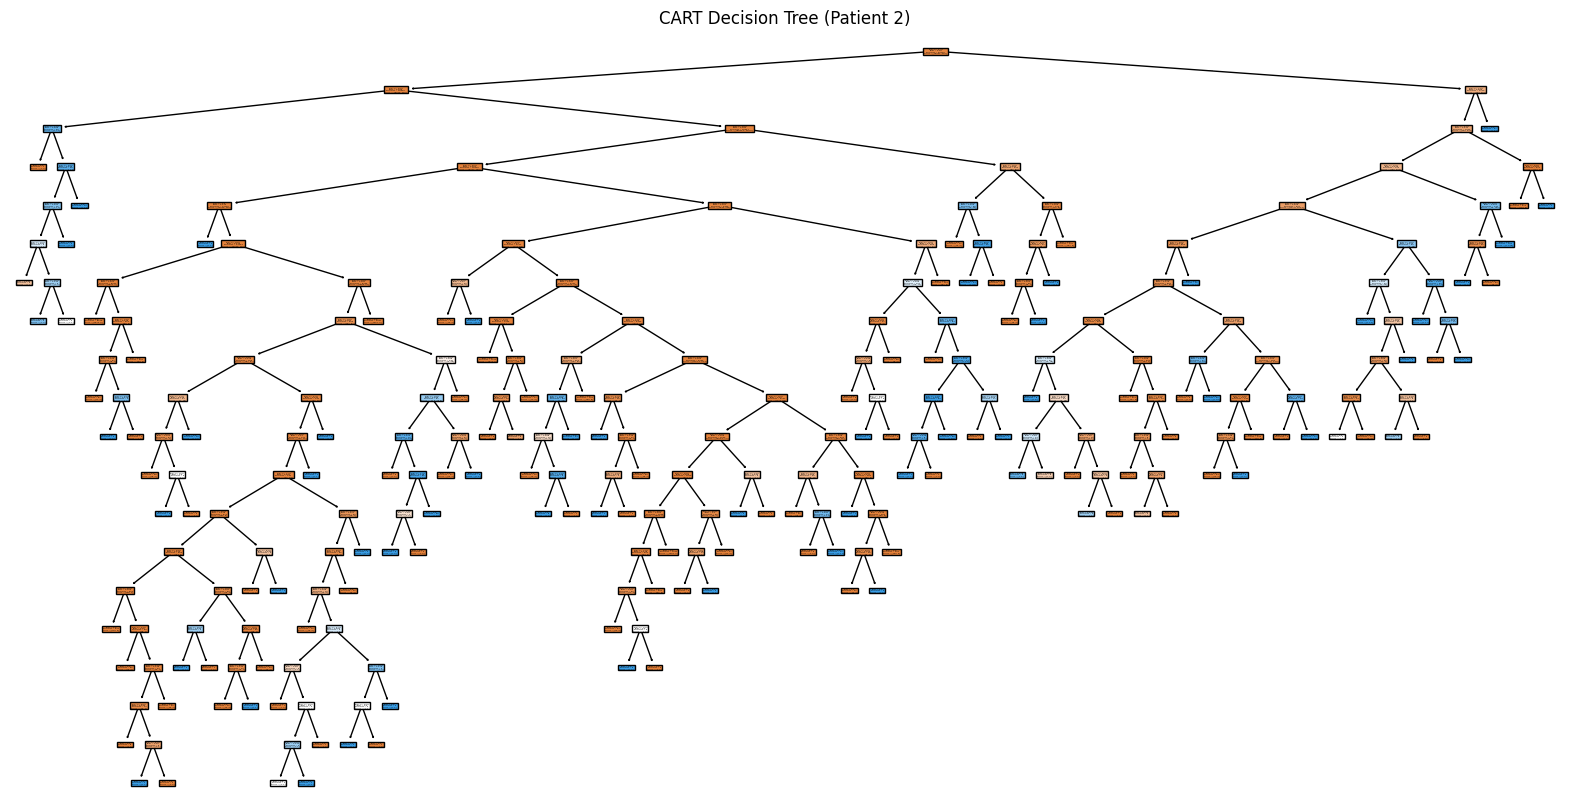

In [10]:
cart_model = DecisionTreeClassifier(criterion='gini', random_state=42)
cart_model.fit(X_train_p2, y_train_p2)

# Predicting and evaluating the model
y_pred_p2 = cart_model.predict(X_test_p2)
accuracy_p2_cart_sklearn = accuracy_score(y_test_p2, y_pred_p2)
print("CART (Scikit-Learn) Accuracy on Patient 2:", accuracy_p2_cart_sklearn)

# Plotting the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(cart_model, filled=True)
plt.title("CART Decision Tree (Patient 2)")
plt.show()

PERFORMANCE METRICS

In [11]:
# Accuracy
accuracy = accuracy_score(y_test_p2, y_pred_p2)
print("Accuracy:", accuracy)
# Precision
precision = precision_score(y_test_p2, y_pred_p2, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_p2, y_pred_p2, average='weighted')
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test_p2, y_pred_p2, average='weighted')
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_p2, y_pred_p2)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report (includes precision, recall, and F1 score for each class)
print("\nClassification Report:\n", classification_report(y_test_p2, y_pred_p2))


Accuracy: 0.9946
Precision: 0.9945850104880246
Recall: 0.9946
F1 Score: 0.9945922196570176
Confusion Matrix:
 [[4819   13]
 [  14  154]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4832
           1       0.92      0.92      0.92       168

    accuracy                           0.99      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.99      0.99      0.99      5000



CART USING TENSORFLOW'S CartModel (PATIENT 2)





In [12]:
# Prepare train and test datasets
train_data = pd.concat([X_train_p2, y_train_p2], axis=1)
test_data = pd.concat([X_test_p2, y_test_p2], axis=1)

#convert dataframe into TensorFlow dataset
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label='Anomaly')
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label='Anomaly')

# Initialize and train CART model
cart_model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)
cart_model.fit(train_dataset)

# Evaluate model
evaluation = cart_model.evaluate(test_dataset)
print(f"Evaluation: {evaluation}")

# Make predictions
predictions = cart_model.predict(test_dataset)


# Visualize the trained tree
tfdf.model_plotter.plot_model_in_colab(cart_model, tree_idx=0)

Use /tmp/tmpg84k_gen as temporary training directory
Reading training dataset...
Training dataset read in 0:00:04.256637. Found 20000 examples.
Training model...
Model trained in 0:00:00.099040
Compiling model...
Model compiled.
5/5 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Evaluation: 0.0
5/5 [==============================] - 0s 6ms/step


In [13]:
# Assuming 'predictions' contains predicted probabilities for each class
predicted_probabilities = predictions.flatten()  # Get probabilities


threshold = 0.3
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Evaluate the adjusted predictions
accuracy_tfdf = accuracy_score(y_test_p2, predicted_labels)
precision_tfdf = precision_score(y_test_p2, predicted_labels, average='weighted', zero_division=1)
recall_tfdf = recall_score(y_test_p2, predicted_labels, average='weighted', zero_division=1)
f1_tfdf = f1_score(y_test_p2, predicted_labels, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy_tfdf}")
print(f"Precision: {precision_tfdf}")
print(f"Recall: {recall_tfdf}")
print(f"F1 Score: {f1_tfdf}")

# Confusion Matrix
conf_matrix_tfdf = confusion_matrix(y_test_p2, predicted_labels)
print(f"\nConfusion Matrix:\n{conf_matrix_tfdf}")
# Classification Report
print(f"\nClassification Report (CART - TensorFlow Decision Forest):\n{classification_report(y_test_p2, predicted_labels)}")

Accuracy: 0.9888
Precision: 0.9894127979199769
Recall: 0.9888
F1 Score: 0.9890452585557062

Confusion Matrix:
[[4796   36]
 [  20  148]]

Classification Report (CART - TensorFlow Decision Forest):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4832
           1       0.80      0.88      0.84       168

    accuracy                           0.99      5000
   macro avg       0.90      0.94      0.92      5000
weighted avg       0.99      0.99      0.99      5000



PERFORMANCE METRICS

**Compare the results from ID3 and CART, identifying their strengths and weaknesses.**

***Analysis:***

ID3 (Scikit-learn) has the best performance overall, with high precision and recall for both classes, though slightly lower for Class 1 (positive).
ID3 (Custom) performs slightly worse, especially in terms of recall for Class 1.
CART shows severe limitations in detecting the positive class, likely due to class imbalance. It achieves 0 recall and 0 precision for Class 1, meaning it fails to identify any true positives.

***Strengths and Weaknesses:***

ID3 (Scikit-learn & Custom)
Strengths:

*High Accuracy*: ID3 provides excellent accuracy, especially with the

*Scikit-learn implementation*:
Good Precision and Recall: ID3 performs well in both precision and recall for identifying the positive class (Patient 1).
Handles Class Imbalance Better: ID3 is more robust in handling imbalanced datasets compared to CART.
Weaknesses:

*Custom Implementation Performance:* The custom implementation slightly underperforms the Scikit-learn version, particularly in terms of recall and handling false negatives.
CART (TensorFlow Decision Forest)
Strengths:

*Good Performance for Class 0 (Negative):* CART performs very well in classifying the majority class (Class 0), with perfect recall and very high precision.
Weaknesses:

*Poor Handling of Imbalanced Data:* CART performs poorly on the minority class (Class 1), as evidenced by its inability to detect any positive cases. This suggests CART may not be well-tuned for datasets with class imbalance.

*Low Recall and Precision for Class 1:* The low recall and precision for Class 1 make CART unsuitable for tasks where detecting the minority class (Patient 1) is critical.

**Conclusion:**

ID3 (Scikit-learn) is the best-performing model across all metrics, making it the most reliable option for this classification task. It offers high accuracy, precision, and recall, even in the presence of class imbalance.
CART (TensorFlow Decision Forest) struggles significantly with class imbalance and performs poorly for the minority class, though it handles the majority class very well.

**Random Forest model using TensorFlow's Decision Forests library**


In [14]:
# Creating a Pandas DataFrame for the Patient 1 training data
train_p1_df = pd.concat([X_train_p1, y_train_p1], axis=1)
train_p1_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_p1_df, label=target)

# Train a Random Forest model
model = tfdf.keras.RandomForestModel()
model.fit(train_p1_tf_dataset)

# Evaluate the model on Patient 1 test data
test_p1_df = pd.concat([X_test_p1, y_test_p1], axis=1)
test_p1_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_p1_df, label=target)

evaluation = model.evaluate(test_p1_tf_dataset)
print(f"Evaluation: {evaluation}")

# Predict on the test set
predictions = model.predict(test_p1_tf_dataset)

# Threshold is set to 0.3 to make the model more sensitive to class 1
threshold = 0.3

predicted_labels = (predictions >= threshold).astype(int)

# Calculate metrics
precision = precision_score(y_test_p1, predicted_labels)
recall = recall_score(y_test_p1, predicted_labels)
f1 = f1_score(y_test_p1, predicted_labels)
accuracy = accuracy_score(y_test_p1, predicted_labels)

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Use /tmp/tmp757iepzh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.290974. Found 19999 examples.
Training model...
Model trained in 0:00:05.319386
Compiling model...
Model compiled.
5/5 [==============================] - 0s 21ms/step - loss: 0.0000e+00
Evaluation: 0.0
5/5 [==============================] - 0s 21ms/step
Accuracy: 0.9916
Precision: 0.9
Recall: 0.9782608695652174
F1 Score: 0.9375


In [15]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

<Figure size 500x500 with 0 Axes>

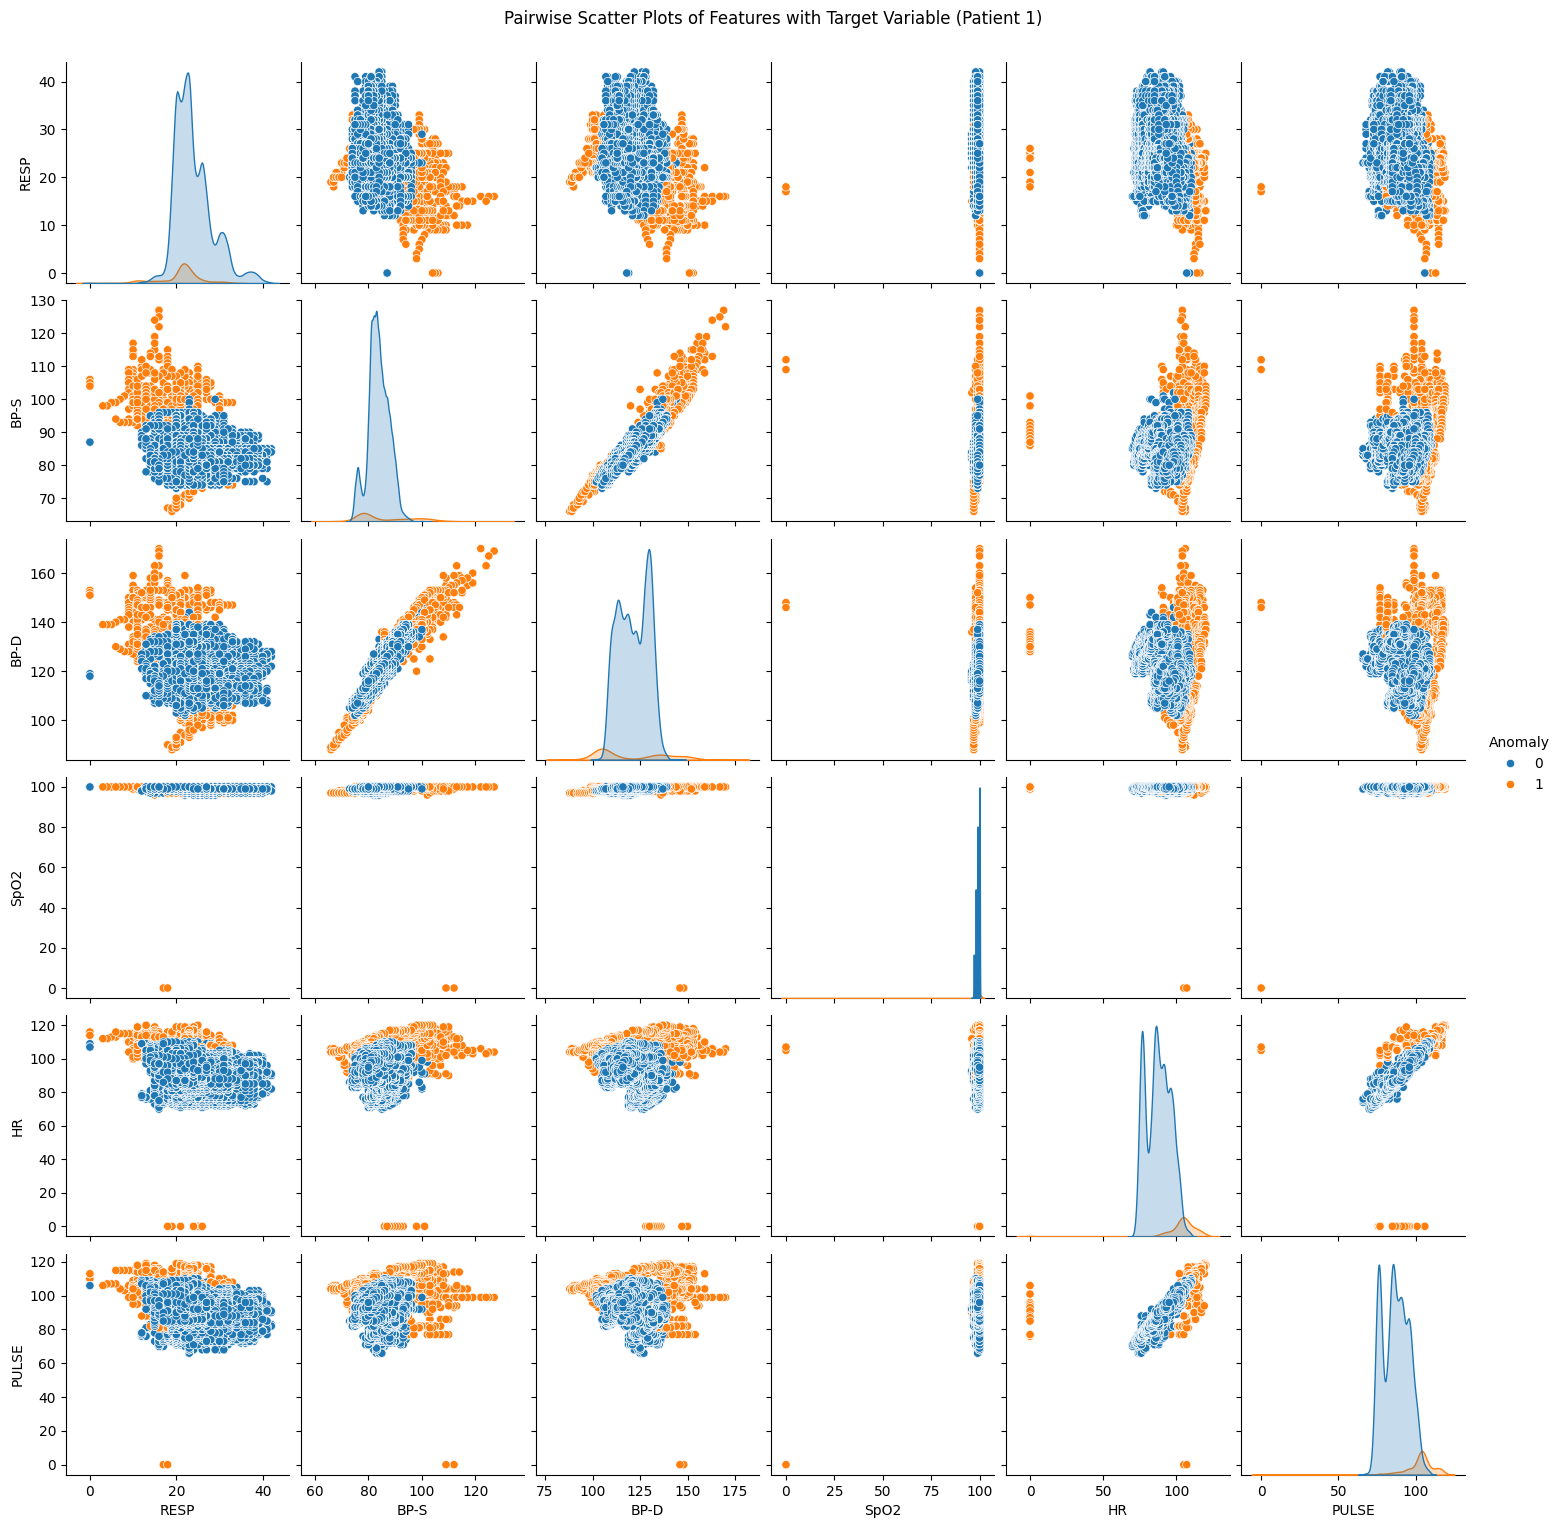

In [16]:
# Creating a pairplot for the Patient 1 dataset with respect to 'Anomaly'
plt.figure(figsize=(5,5))
sns.pairplot(df1, hue='Anomaly')

plt.suptitle('Pairwise Scatter Plots of Features with Target Variable (Patient 1)', y=1.02)
plt.show()

<Figure size 500x500 with 0 Axes>

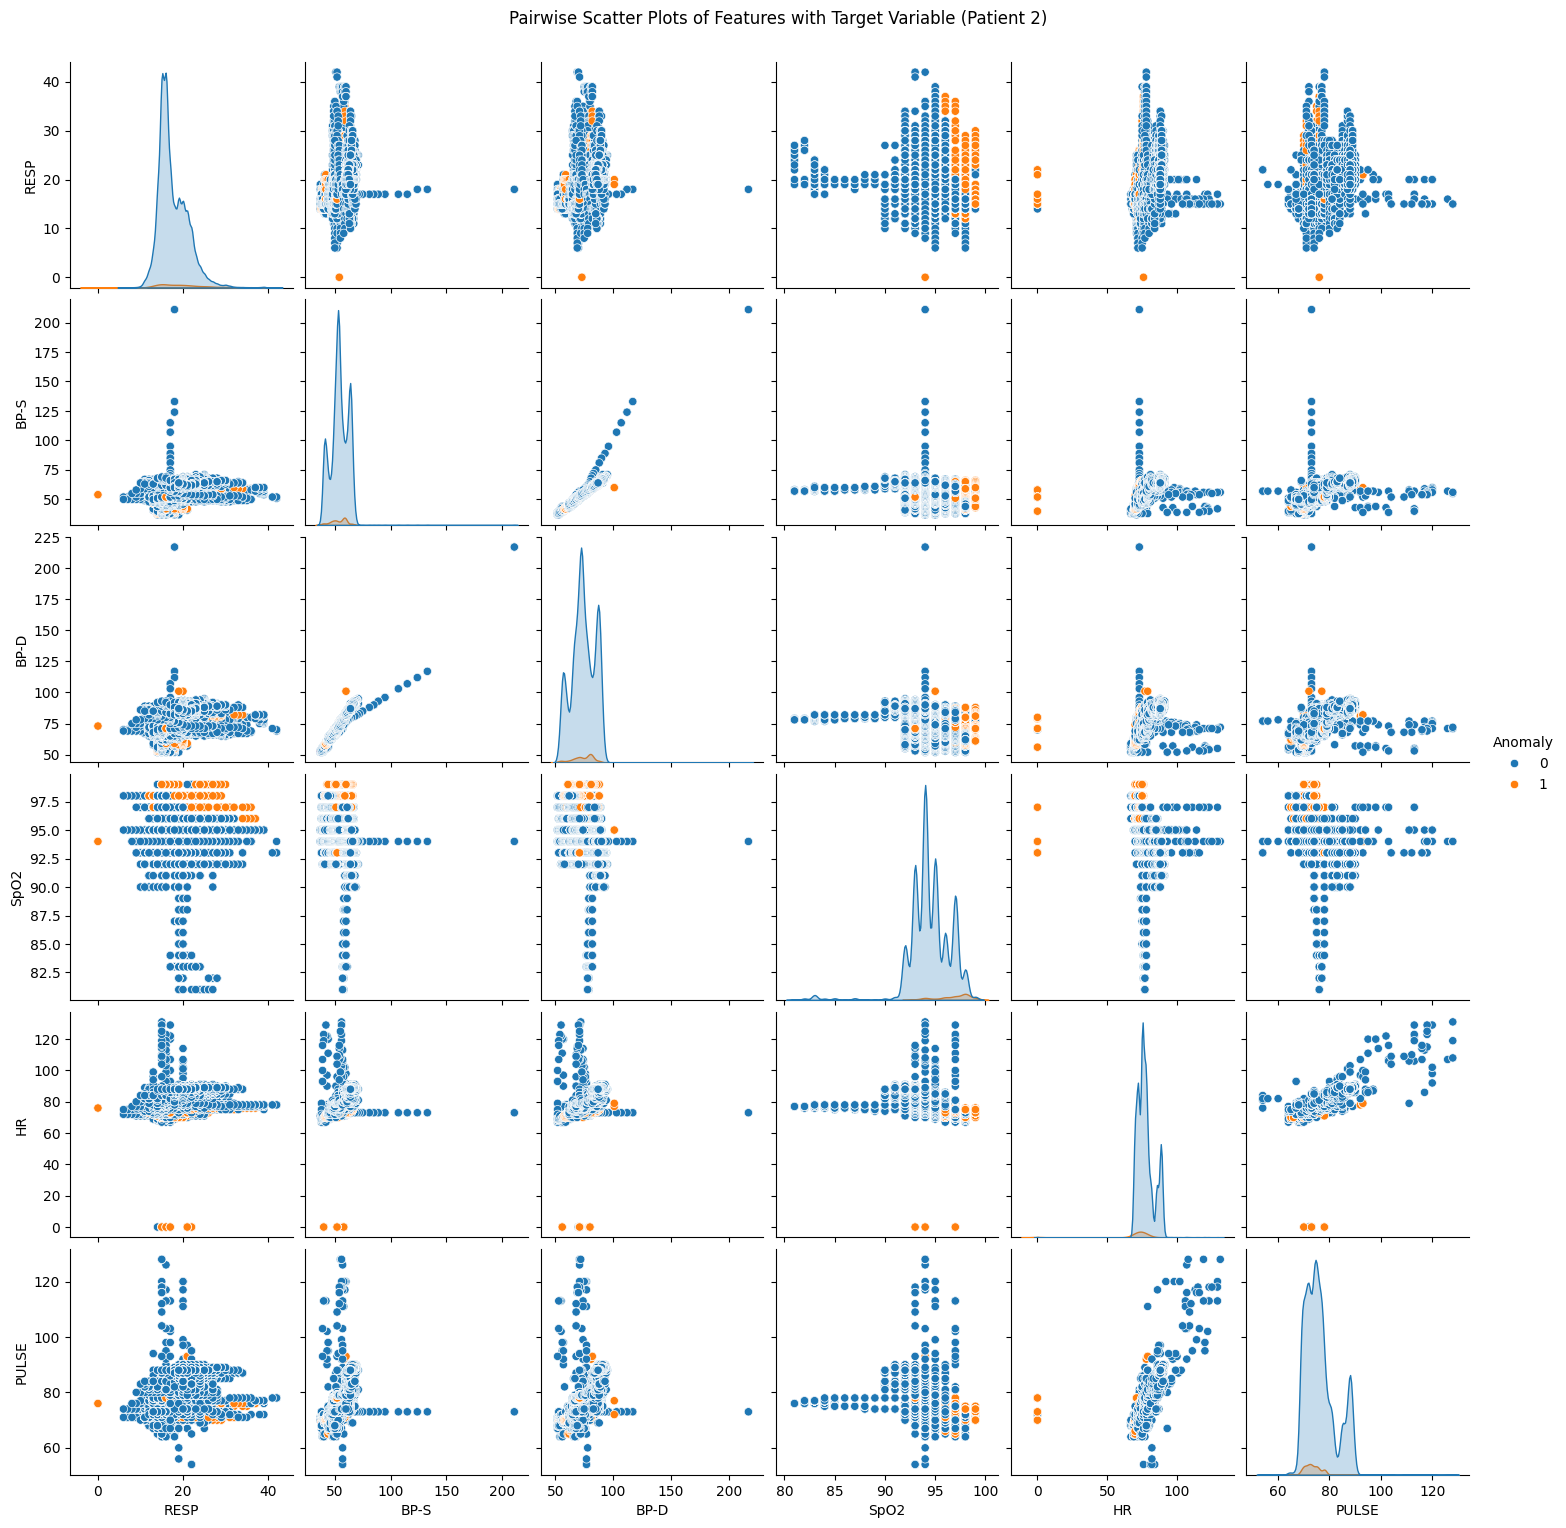

In [17]:
# Creating a pairplot for the Patient 2 dataset with respect to 'Anomaly'
plt.figure(figsize=(5,5))
sns.pairplot(df2, hue='Anomaly')

plt.suptitle('Pairwise Scatter Plots of Features with Target Variable (Patient 2)', y=1.02)
plt.show()

# Gradient Boosted Decision Trees Implementation

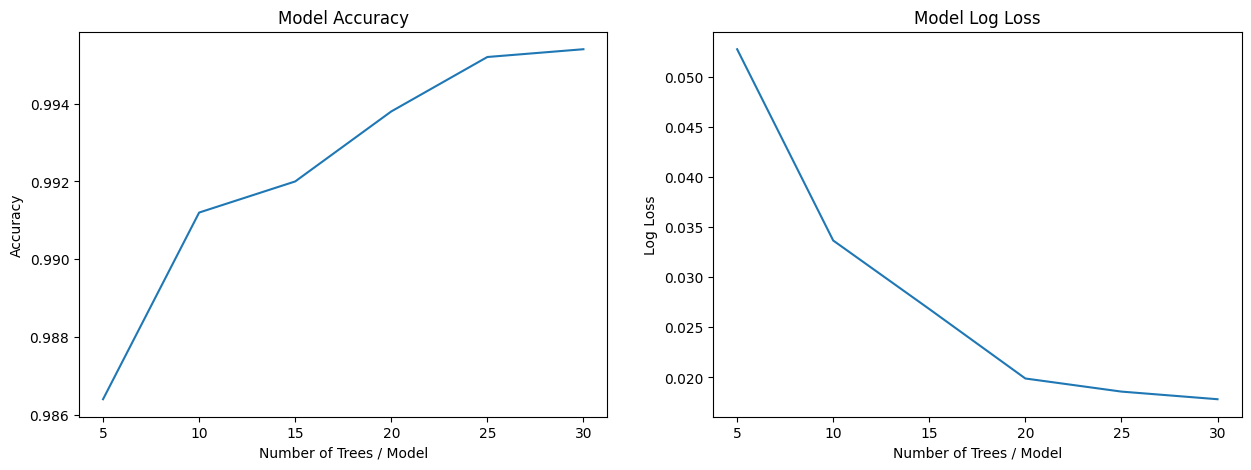

In [18]:
# Number of hyperparameters to test
n_estimators_range = [5, 10, 15, 20, 25, 30]

# Variables to store results
accuracy_results = []
log_loss_results = []

# Gradient Boosting Model
for n_estimators in n_estimators_range:
    gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.3, max_depth=5, random_state=0)
    gb.fit(X_train_p2, y_train_p2)

    y_pred = gb.predict(X_test_p2)
    y_pred_proba = gb.predict_proba(X_test_p2)

    accuracy = accuracy_score(y_test_p2, y_pred)
    logloss = log_loss(y_test_p2, y_pred_proba)

    accuracy_results.append(accuracy)
    log_loss_results.append(logloss)

# Plotting the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(n_estimators_range , accuracy_results)
plt.title('Model Accuracy')
plt.xlabel('Number of Trees / Model')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, log_loss_results)
plt.title('Model Log Loss')
plt.xlabel('Number of Trees / Model')
plt.ylabel('Log Loss')

plt.show()


In [19]:
# For Random Forest model
inspector_rf = model.make_inspector()
feature_importances_rf = inspector_rf.variable_importances()
print("Random Forest Feature Importances:", feature_importances_rf)

Random Forest Feature Importances: {'INV_MEAN_MIN_DEPTH': [("HR" (1; #2), 0.46646792949891275), ("BP-D" (1; #0), 0.3882259440754293), ("PULSE" (1; #3), 0.19030234949274905), ("BP-S" (1; #1), 0.18204018629757474), ("SpO2" (1; #5), 0.13634357065228553), ("RESP" (1; #4), 0.1295869013853211)], 'NUM_AS_ROOT': [("HR" (1; #2), 190.0), ("PULSE" (1; #3), 81.0), ("BP-D" (1; #0), 29.0)], 'SUM_SCORE': [("HR" (1; #2), 554775.4792940828), ("BP-D" (1; #0), 305710.92747760867), ("PULSE" (1; #3), 220254.1038811906), ("BP-S" (1; #1), 142593.29386647113), ("SpO2" (1; #5), 136264.11300203484), ("RESP" (1; #4), 50684.312205102295)], 'NUM_NODES': [("BP-D" (1; #0), 6498.0), ("BP-S" (1; #1), 5918.0), ("RESP" (1; #4), 5810.0), ("PULSE" (1; #3), 5456.0), ("HR" (1; #2), 5224.0), ("SpO2" (1; #5), 1828.0)]}


In [20]:
# For Gradient Boosting model
feature_importances_gbdt = gb.feature_importances_
print("Feature importances for GBDT model:")
print(feature_importances_gbdt)

Feature importances for GBDT model:
[0.17114509 0.13603533 0.20431581 0.20940275 0.23788274 0.04121828]
